![Cover](https://github.com/AniMilina/CAFA-5-Protein-Function-Prediction/raw/main/CAFA%205%20Protein%20Function%20Prediction.jpg)


**From the author:** Hello everyone! My name is Milina, medicine and everything connected with it is my favorite topic of research. I’ll be honest, I didn’t see the result of the model that would suit me. But it was important for me to see that the model was stable, and that the model’s settings could be adjusted to a good result over time.

I created a couple of additional features that expanded the range of research. Proteins in organisms is a very, very broad topic that requires maximum immersion. But I will be glad if my work is useful in your research and discoveries.

I want to say a big thank you to: https://www.kaggle.com/gusthema https://www.kaggle.com/elliot2robot and https://www.kaggle.com/sergeifironov Without you, the submission file would have completely tortured me

I wish you all good luck and new discoveries!

## Project description

`Purpose of the competition:`  

>The goal of this competition is to create a model to predict the functions of a set of proteins. The model will be trained on amino acid sequences of proteins and other available data  
The work aims to help researchers better understand the functions of proteins, which is important for uncovering how cells, tissues and organs work. It could also help develop new drugs and therapies for various diseases  

`Context:`  

>Proteins play an important role in a variety of activities in tissues, organs and the body as a whole, and also influence the structure and function of cells  
They are large molecules consisting of 20 types of amino acids. There are tens of thousands of different proteins in the human body, and each protein consists of tens or hundreds of amino acids linked in series  
This amino acid sequence determines the 3D structure and conformational dynamics of the protein, which in turn determines its biological function. Due to genome sequencing projects, we have enormous amounts of genetic sequence data from thousands of species, which provides information about the amino acid sequence of the proteins that are encoded by these genes  
Precise assignment of biological function to a protein is key to understanding life at the molecular level. However, the task of assigning a function to a specific protein is complicated by the multiple functions of many proteins, as well as their ability to interact with multiple partners  
More knowledge about the functions assigned to proteins could lead to the development of treatments for diseases and improvements in human and animal health in areas such as medicine and agriculture  

`Data files:`  

**go-basic.obo:** GO ontology in OBO format  
**train_sequences.fasta:** Protein sequences for the training dataset  
**train_terms.tsv:** GO annotations for proteins from the training set  
**train_taxonomy.tsv:** Taxa for proteins from the training set  
**IA.txt:** Weights for each term used to calculate weighted precision and recall  
**testsuperset.fasta:** Protein sequences for predictions  
**testsuperset-taxon-list.tsv:** Taxa for proteins in the test superset  

## Installing and importing libraries

In [1]:
!pip install obonet pandas
# # !pip install biopython

In [2]:
import obonet
import pandas as pd

import warnings
import time

from Bio import SeqIO
from Bio.SeqUtils import ProtParam

import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score,classification_report

import tensorflow as tf
from keras import backend as K
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from keras.utils import Sequence
from keras.layers import Input, Embedding, LSTM, Dense, concatenate,Dropout
from keras.models import Model,load_model

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Settings

In [3]:
# Disable warnings

warnings.filterwarnings('ignore')

In [4]:
class f:    
    BOLD = "\033[1m"     # Bold text
    ITALIC = "\033[3m"   # Italic text
    END = "\033[0m"      # Reset style

## Functions

In [5]:
def explore_data(dataframes):
    for name, df in dataframes.items():
        print(f"\n{name} Data:")
        print(f"Shape:\n{df.shape}")
        print(f"\nInfo:")
        df.info()
        print(f"\nDuplicates:")
        duplicates = df[df.duplicated()]
        print(duplicates)
        print(f"\nMissing Values:")
        missing_values = df.isnull().sum()
        print(missing_values[missing_values > 0])

In [6]:
def visualize_distribution(data, x, title, xlabel, ylabel, facecolor='lightgray', gridcolor='gray', colors=None, rotation=0):
    """
    Visualization of data distribution.

    Options:
    - data: DataFrame, data for visualization.
    - x: str, column name for the X axis.
    - title: str, title of the graph.
    - xlabel: str, X-axis label.
    - ylabel: str, Y-axis label.
    - facecolor: str, background color of the chart.
    - gridcolor: str, color of the chart grid.
    - colors: list, additional colors for the chart.
    - rotation: int, the angle of rotation of the labels.

    Returns:
    None
    """
    plt.figure(figsize=(10, 6))
    sns.set_palette(colors) if colors else None
    sns.countplot(x=x, data=data)
    sns.set(style="whitegrid")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    ax = plt.gca()
    ax.set_facecolor(facecolor)
    ax.grid(color=gridcolor)
    plt.xticks(rotation=rotation)

    plt.show()


## Read data

In [7]:
obo_path = '/kaggle/input/cafa-5-protein-function-prediction/Train/go-basic.obo'
graph = obonet.read_obo(obo_path)

In [8]:
# graph

In [9]:
fasta_path = "/kaggle/input/cafa-5-protein-function-prediction/Train/train_sequences.fasta"
terms_path = "/kaggle/input/cafa-5-protein-function-prediction/Train/train_terms.tsv"
taxonomy_path = "/kaggle/input/cafa-5-protein-function-prediction/Train/train_taxonomy.tsv"
ia_path = "/kaggle/input/cafa-5-protein-function-prediction/IA.txt"

In [10]:
fasta_data = pd.DataFrame([(record.id, str(record.seq)) for record in SeqIO.parse(fasta_path, "fasta")], columns=['Protein_ID', 'Sequence'])
terms_data = pd.read_csv(terms_path, sep='\t', header=None, names=['Protein_ID', 'GO_Term_ID', 'Ontology'])
taxonomy_data = pd.read_csv(taxonomy_path, sep='\t', header=None, names=['Protein_ID', 'Taxon_ID'])
ia_data = pd.read_csv(ia_path, sep='\t', header=None, names=['GO_Term_ID', 'Weight'])

In [11]:
print("Fasta Data:")
display(fasta_data.head())

print("\nTerms Data:")
display(terms_data.head())

print("\nTaxonomy Data:")
display(taxonomy_data.head())

print("\nIA Data:")
display(ia_data.head())

Fasta Data:


,Protein_ID,Sequence
0,P20536,MNSVTVSHAPYTITYHDDWEPVMSQLVEFYNEVASWLLRDETSPIP...
1,O73864,MTEYRNFLLLFITSLSVIYPCTGISWLGLTINGSSVGWNQTHHCKL...
2,O95231,MRLSSSPPRGPQQLSSFGSVDWLSQSSCSGPTHTPRPADFSLGSLP...
3,A0A0B4J1F4,MGGEAGADGPRGRVKSLGLVFEDESKGCYSSGETVAGHVLLEAAEP...
4,P54366,MVETNSPPAGYTLKRSPSDLGEQQQPPRQISRSPGNTAAYHLTTAM...



Terms Data:


,Protein_ID,GO_Term_ID,Ontology
0,EntryID,term,aspect
1,A0A009IHW8,GO:0008152,BPO
2,A0A009IHW8,GO:0034655,BPO
3,A0A009IHW8,GO:0072523,BPO
4,A0A009IHW8,GO:0044270,BPO



Taxonomy Data:


,Protein_ID,Taxon_ID
0,EntryID,taxonomyID
1,Q8IXT2,9606
2,Q04418,559292
3,A8DYA3,7227
4,Q9UUI3,284812



IA Data:


,GO_Term_ID,Weight
0,GO:0000001,0.000000
1,GO:0000002,3.103836
2,GO:0000003,3.439404
3,GO:0000011,0.056584
4,GO:0000012,6.400377


## Let's check the received data

In [12]:
dataframes = {
    'Fasta': fasta_data,
    'Terms': terms_data,
    'Taxonomy': taxonomy_data,
    'IA': ia_data
}

In [13]:
explore_data(dataframes)


Fasta Data:
Shape:
(142246, 2)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142246 entries, 0 to 142245
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Protein_ID  142246 non-null  object
 1   Sequence    142246 non-null  object
dtypes: object(2)
memory usage: 2.2+ MB

Duplicates:
Empty DataFrame
Columns: [Protein_ID, Sequence]
Index: []

Missing Values:
Series([], dtype: int64)

Terms Data:
Shape:
(5363864, 3)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5363864 entries, 0 to 5363863
Data columns (total 3 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   Protein_ID  object
 1   GO_Term_ID  object
 2   Ontology    object
dtypes: object(3)
memory usage: 122.8+ MB

Duplicates:
Empty DataFrame
Columns: [Protein_ID, GO_Term_ID, Ontology]
Index: []

Missing Values:
Series([], dtype: int64)

Taxonomy Data:
Shape:
(142247, 2)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142

`Fast Data:`   

>Data form: (142246, 2) - 142246 rows and 2 columns  
Data types: Protein_ID and Sequence are represented by string data  
No duplicates  
No missing values  

**Conclusions: The Fasta dataset contains protein sequences for 142,246 unique protein IDs with no duplicates or missing values**  

`Terms Data:`  

>Data form: (5363864, 3) - 5363864 rows and 3 columns  
Data types: Protein_ID, GO_Term_ID and Ontology are represented by string data  
No duplicates  
No missing values  

**Conclusions: The Terms dataset contains GO annotations for proteins covering more than 5 million records. No duplicates or missing values**  

`Taxonomy Data:`  

>Data form: (142247, 2) - 142247 rows and 2 columns  
Data types: Protein_ID and Taxon_ID are represented by string data  
No duplicates  
No missing values  

**Conclusions: The Taxonomy dataset contains taxonomy information for 142,247 unique protein identifiers with no duplicates or missing values**  

`IA Data:`  

>Data form: (43248, 2) - 43248 rows and 2 columns  
Data types: GO_Term_ID is represented by string data, and Weight is represented by numeric data  
No duplicates  
No missing values  

**Conclusions: The IA dataset contains information about information richness (weights) for GO terms**  
 
#### General conclusions:  

All datasets do not contain duplicates or missing values  
The Terms dataset is large and contains GO annotations for proteins, and Fasta contains the corresponding sequences  
IA contains weights for GO terms and Taxonomy provides protein taxonomy information  

## Data processing

In [14]:
# Transform protein sequences

fasta_data['Sequence'] = fasta_data['Sequence'].str.replace('\n', '')

In [15]:
merged_data = pd.merge(terms_data, taxonomy_data, on='Protein_ID')

In [16]:
merged_data = pd.merge(merged_data, fasta_data[['Protein_ID', 'Sequence']], on='Protein_ID')

In [17]:
# Let's look at the weights from IA.txt

merged_data = pd.merge(merged_data, ia_data, on='GO_Term_ID')

In [18]:
merged_data

,Protein_ID,GO_Term_ID,Ontology,Taxon_ID,Sequence,Weight
0,A0A009IHW8,GO:0008152,BPO,1310613,MSLEQKKGADIISKILQIQNSIGKTTSPSTLKTKLSEISRKEQENA...,1.598544
1,A0A023I7E1,GO:0008152,BPO,4839,MRFQVIVAAATITMITSYIPGVASQSTSDGDDLFVPVSNFDPKSIF...,1.598544
2,A0A024CBD6,GO:0008152,BPO,9823,MMAFCALRKALPCRPENPFSSRCFVEILWVSLALVFLLPMPSDACD...,1.598544
3,A0A024RAD5,GO:0008152,BPO,9606,MGYFRCAGAGSFGRRRKMEPSTAARAWALFWLLLPLLGAVCASGPR...,1.598544
4,A0A031WDE4,GO:0008152,BPO,1496,MARGTFERTKKLREESINAEPHISIERAVLMTEAYKKYEGSVEIPV...,1.598544
...,...,...,...,...,...,...
5363858,Q9VMG0,GO:0019186,MFO,7227,MSAITIRAMTIGDYEEVEAFLAVHFFKQEPLMLIPQEDPKQSEVSS...,7.592457
5363859,Q9XHE6,GO:0018674,MFO,34256,MELLQLWSALIILVVTYTISLLINQWRKPKPQGKFPPGPPKLPLIG...,0.415037
5363860,Q9XHE7,GO:0018674,MFO,34256,MELQISSAIIILVVTYTISLLIIKQWRKPKPQENLPPGPPKLPLIG...,0.415037
5363861,Q9Z4P6,GO:0050002,MFO,499177,MSITLESAKEHANDLAVLCCRAEEGTVIGPSNLEDPAIFGDLEDSG...,0.000000


#### We received a new, ready-to-use dataset. What can you say about it:  

`Dataset size:` The dataset contains 6 columns and 5363863 rows  

`Data types:` Basically, all columns contain string (object) and numeric (float64) values  

`No duplicates:` According to the data presented, there are no duplicates, since the "Duplicates" column in the explore_data output was empty  

`No missing values:` All columns have no missing values, making data analysis easier  

`Weight Values:` Based on the "Weight" column, weights are associated with each unique GO term. Weights can be important for assessing model quality, especially when using weighted metrics  

`Distribution of GO terms:` The dataset includes terms from different ontologies (Biological Process, Molecular Function), which allows you to take into account various aspects of gene function  

`Taxon:` Taxon information (Taxon_ID) is present, which can be useful when training a model taking into account taxonomic information  

## Let's examine the `go-basic.obo` file, especially in the context of the GO biological ontology. Consider incorporating a hierarchy of terms into training 


In [19]:
# Display information about the graph structure

print("Number of nodes:", graph.number_of_nodes())
print("Number of edges:", graph.number_of_edges())

# Print the first few nodes of the graph

print("\nFirst few nodes in the graph:")
for i, (node, data) in enumerate(graph.nodes(data=True)):
     if i < 5:
        print(f"{node}: {data}")

# Print the first few edges of the graph

print("\nFirst few edges in the graph:")
for i, (source, target, data) in enumerate(graph.edges(data=True)):
     if i < 5:
        print(f"{source} -> {target}: {data}")

Number of nodes: 43248
Number of edges: 84805

First few nodes in the graph:
GO:0000001: {'name': 'mitochondrion inheritance', 'namespace': 'biological_process', 'def': '"The distribution of mitochondria, including the mitochondrial genome, into daughter cells after mitosis or meiosis, mediated by interactions between mitochondria and the cytoskeleton." [GOC:mcc, PMID:10873824, PMID:11389764]', 'synonym': ['"mitochondrial inheritance" EXACT []'], 'is_a': ['GO:0048308', 'GO:0048311']}
GO:0000002: {'name': 'mitochondrial genome maintenance', 'namespace': 'biological_process', 'def': '"The maintenance of the structure and integrity of the mitochondrial genome; includes replication and segregation of the mitochondrial chromosome." [GOC:ai, GOC:vw]', 'is_a': ['GO:0007005']}
GO:0000003: {'name': 'reproduction', 'namespace': 'biological_process', 'alt_id': ['GO:0019952', 'GO:0050876'], 'def': '"The production of new individuals that contain some portion of genetic material inherited from one 

#### The results of the analysis of the `go-basic.obo` file allow us to draw the following conclusions:  

`Number of nodes and edges:`  

>Total nodes: 43,248  
Total ribs: 84,805  

`Examples of nodes:`  

>GO:0000001: "mitochondrion inheritance" in the space of biological processes  
GO:0000002: "mitochondrial genome maintenance" in the space of biological processes  
GO:0000003: "reproduction" in the space of biological processes  
GO:0000006: "high-affinity zinc transmembrane transporter activity" in molecular function space  
GO:0000007: "low-affinity zinc ion transmembrane transporter activity" in molecular function space  

`Structure of nodes and edges:`  

>Nodes represent terms in the GO ontology that describe biological processes, molecular functions, and cell components  
Edges represent relationships between terms, such as the "is_a" relationship (which is a subtype)  

`Information in nodes:`  

>Nodes contain information about the term, its description, namespace membership, synonyms, alternative identifiers and other properties  

`Hierarchy:`  

>The GO ontology has a hierarchical structure, where some terms are subtypes of others
These findings highlight the importance of term hierarchy structure in a GO ontology, which can be useful when training a model to predict protein functions  

## Exploratory Data Analysis

In [20]:
# Get a random subsample of 50% of the data  

merged_data_sample = merged_data.sample(frac=0.5, random_state=12345)

In [21]:
merged_data_sample 

,Protein_ID,GO_Term_ID,Ontology,Taxon_ID,Sequence,Weight
1688184,A0A8I5ZYP2,GO:0048519,BPO,10116,MANDSPAKSLVDIDLSSLRDPAGIFELVEVVGNGTYGQVYKGRHVK...,1.348521
1018422,Q969Q5,GO:0005622,CCO,9606,MSGQRVDVKVVMLGKEYVGKTSLVERYVHDRFLVGPYQNTIGAAFV...,0.366945
5091231,F1NUT2,GO:2000833,BPO,9031,MPEGRVPRRGSPAPPAPPPSRRRRRRRLAAMPVGRGQPASWLLVLG...,0.000000
2530179,P92973,GO:0097159,MFO,3702,METNSSGEDLVIKTRKPYTITKQRERWTEEEHNRFIEALRLYGRAW...,2.154321
4861188,Q9SMU8,GO:0005618,CCO,3702,MHFSSSSTSSTWTILITLGCLMLHASLSAAQLTPTFYDRSCPNVTN...,1.164078
...,...,...,...,...,...,...
4439579,Q8QZS3,GO:0043409,BPO,10090,MNAIVALCHFCELHGPRTLFCTEVLHAPLPQGAGSGDSPDQVEQAE...,0.133524
1974659,M9MSM5,GO:0022603,BPO,7227,MSSMNQMSVLMDKINTTLQSCPIVCINEPDTHSANTEILQTSPEST...,1.715892
814866,Q84TH8,GO:0032502,BPO,3702,MASISTASSSSSLLFPSRNFKSIPLLPQQRSSVSFVRCFSKNSSTE...,1.684844
3320049,I3L2R2,GO:0005654,CCO,9606,XWLVETQVKARRRKRGAQKGSGSPTHSLSQKSTRLSGAAPAHSAAD...,0.347215


#### Search for anomalies:  

To find anomalies in the data, we can look at several aspects such as:  

`Length of protein sequences`  

Let's build a histogram of the length distribution of protein sequences  
We investigate the presence of incorrect values or outliers in the length distribution  

`GO Terms`  

Let's check if there are protein sequences with unusual or incorrect GO terms  
Let's look at the distribution of frequency of use of various terms   

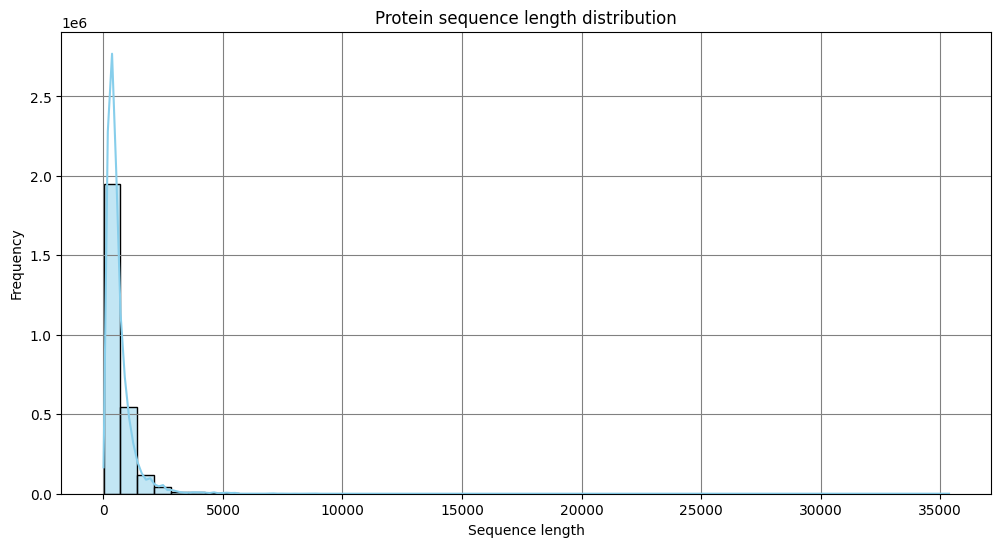

In [22]:
facecolor='white'
gridcolor='gray'

plt.figure(figsize=(12, 6))
sns.histplot(merged_data_sample['Sequence'].apply(len), bins=50, kde=True, color='skyblue')
sns.set(style="whitegrid")
plt.title('Protein sequence length distribution')
plt.xlabel('Sequence length')
plt.ylabel('Frequency')
ax = plt.gca()
ax.set_facecolor(facecolor)
ax.grid(color=gridcolor)
plt.show()

#### Comparison between training and test set:

In [23]:
test_sequences = [str(record.seq) for record in SeqIO.parse('/kaggle/input/cafa-5-protein-function-prediction/Test (Targets)/testsuperset.fasta', 'fasta')]
test_taxonomy = pd.read_csv('/kaggle/input/cafa-5-protein-function-prediction/Test (Targets)/testsuperset-taxon-list.tsv', sep='\t', encoding='ISO-8859-1')

In [24]:
test_taxonomy.head(3)

,ID,Species
0,9606,homo sapiens[All Names]
1,10090,mus musculus[All Names]
2,10116,Rattus norvegicus


In [25]:
# test_sequences

In [26]:
# Again we make a random sample that will equalize the number of lines in the train and test, 
# of course this reduces the accuracy, but as an experiment you can try

merged_data_for_test = merged_data.sample(frac=0.0000168, random_state=12345)

In [27]:
# merged_data_for_test

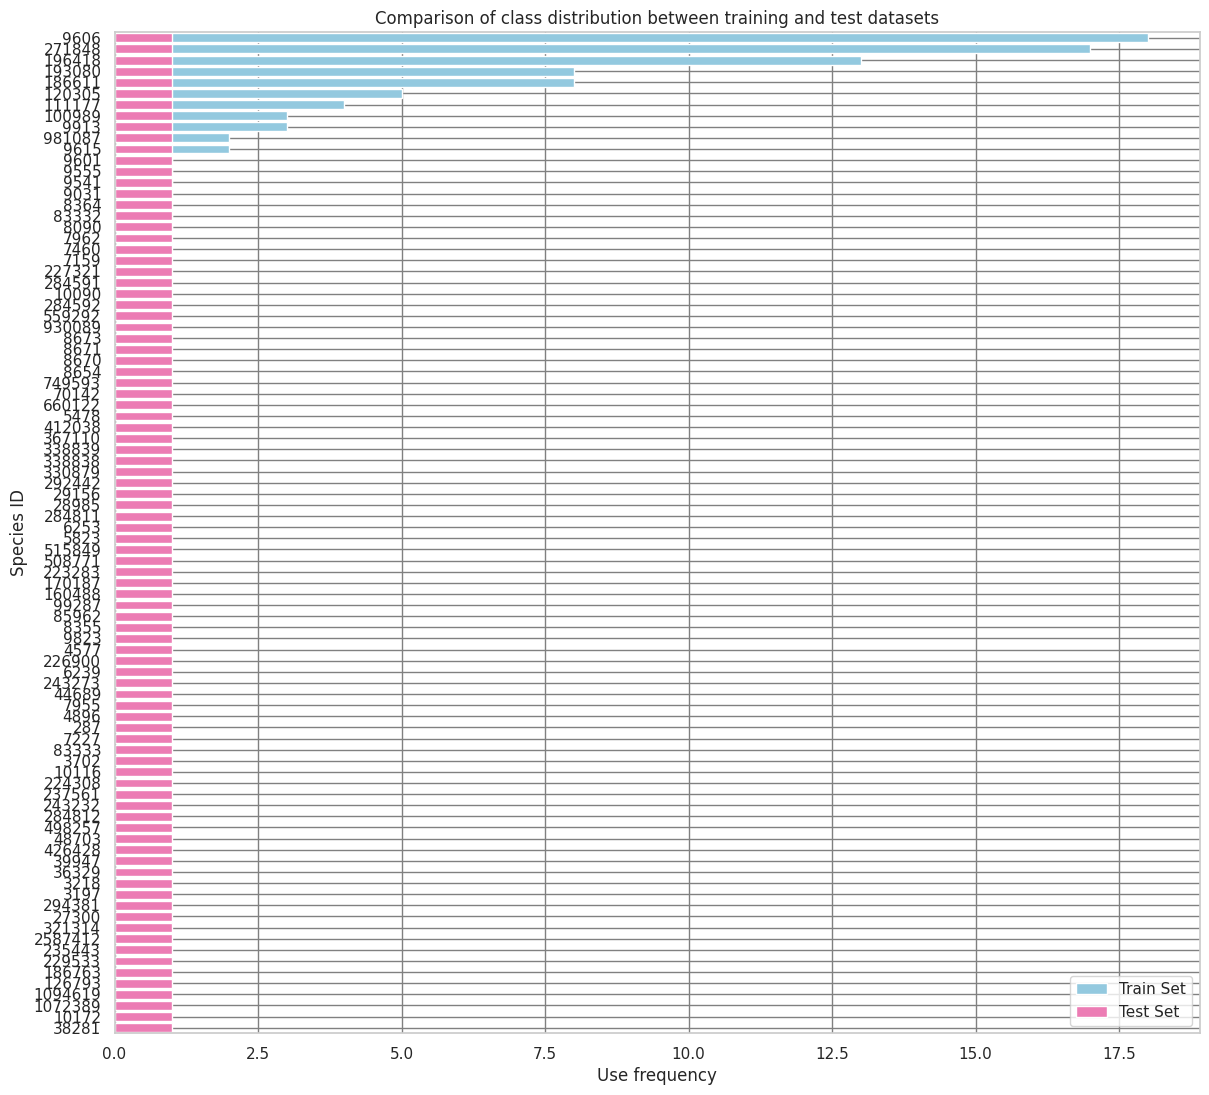

In [28]:
# Comparison of class distribution

plt.figure(figsize=(14, 13))
sns.countplot(y='Taxon_ID', data=merged_data_for_test,
               order=merged_data_for_test['Taxon_ID'].value_counts().index, color='skyblue',label='Train Set')
sns.countplot(y='ID', data=test_taxonomy,
               order=test_taxonomy['ID'].value_counts().index, color='hotpink', label='Test Set')
plt.title('Comparison of class distribution between training and test datasets')
plt.xlabel('Use frequency')
plt.ylabel('Species ID')
ax = plt.gca()
ax.set_facecolor(facecolor)
ax.grid(color=gridcolor)
plt.legend()
plt.show()

The comparison is meaningless, since in the test each protein is presented in one copy, but it is interesting now to look at the distribution of species in the train 

Since there are 90 types of proteins, and the maximum number of one type is 1,064,498, I will make the threshold 1% of this number

In [29]:
threshold = 10645

taxon_counts = merged_data['Taxon_ID'].value_counts()

filtered_taxon_counts = taxon_counts[(taxon_counts >= threshold) & (taxon_counts <= taxon_counts.max())]

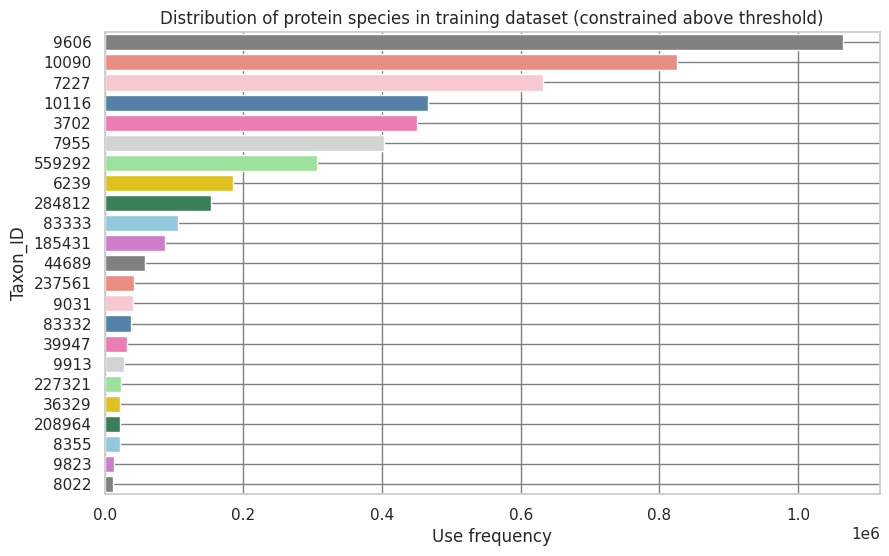

In [30]:
colors = ['gray', 'salmon', 'pink', 'steelblue', 'hotpink', 'lightgray', 'lightgreen', 'gold', 'seagreen', 'skyblue', 'orchid']

plt.figure(figsize=(10, 6))
sns.barplot(x=filtered_taxon_counts.values, y=filtered_taxon_counts.index, palette=colors)
plt.title('Distribution of protein species in training dataset (constrained above threshold)')
plt.xlabel('Use frequency')
plt.ylabel('Taxon_ID')
ax = plt.gca()
ax.set_facecolor(facecolor)
ax.grid(color=gridcolor)

plt.show()

Obviously - a huge part of the protein protein species belongs to the minority

## Research part. Creating New Features

Let's create additional features based on protein sequences. The choice of letters to represent amino acids is based on abbreviations used in bioinformatics and molecular biology. Each letter represents an abbreviation for a specific amino acid. Here's what these abbreviations mean:  

A: Alanine  
C: Cysteine  
D: Aspartic acid  
E: Glutamic acid  
F: Phenylalanine  
G: Glycine  
H: Histidine  
I: Isoleucine  
K: Lysine  
L: Leucine  
M: Methionine  
N: Asparagine  
P: Proline  
Q: Glutamine  
R: Arginine  
S: Serine  
T: Threonine  
V: Valine  
W: Tryptophan  
Y: Tyrosine  

These letters represent the basic 20 standard amino acids that make up proteins. In bioinformatics they are widely used to represent sequences of proteins and nucleotides (in the case of nucleic acids)

## NB!

I had to create an experimental dataset `merged_data_sample` since both locally and on Kaggle the kernel crashed on the next part. Then you can change the frac parameter and increase the random sample accordingly

In [31]:
# Receive a random subsample of 10% of the data

merged_data_sample = merged_data.sample(frac=0.1, random_state=42)

In [32]:
def calculate_amino_acid_statistics(sequence):
    valid_amino_acids = set("ACDEFGHIKLMNPQRSTVWY")  # Allowed amino acids
    
    filtered_sequence = "".join(aa for aa in sequence if aa.upper() in valid_amino_acids)
    
    if not filtered_sequence:
        return pd.Series([np.nan, np.nan, np.nan, np.nan], index=['MolecularWeight', 'Aromaticity', 'InstabilityIndex', 'IsoelectricPoint'])
    
    protein_analyzer = ProtParam.ProteinAnalysis(str(filtered_sequence))
    
    mol_weight = protein_analyzer.molecular_weight()
    aromaticity = protein_analyzer.aromaticity()
    instability_index = protein_analyzer.instability_index()
    isoelectric_point = protein_analyzer.isoelectric_point()
    
    return pd.Series([mol_weight, aromaticity, instability_index, isoelectric_point], index=['MolecularWeight', 'Aromaticity', 'InstabilityIndex', 'IsoelectricPoint'])


In [33]:
merged_data_sample[['MolecularWeight', 'Aromaticity', 'InstabilityIndex', 'IsoelectricPoint']] = merged_data_sample['Sequence'].apply(calculate_amino_acid_statistics)

In [34]:
merged_data_sample.info()

<class 'pandas.core.frame.DataFrame'>
Index: 536386 entries, 5259497 to 1167483
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Protein_ID        536386 non-null  object 
 1   GO_Term_ID        536386 non-null  object 
 2   Ontology          536386 non-null  object 
 3   Taxon_ID          536386 non-null  object 
 4   Sequence          536386 non-null  object 
 5   Weight            536386 non-null  float64
 6   MolecularWeight   536386 non-null  float64
 7   Aromaticity       536386 non-null  float64
 8   InstabilityIndex  536386 non-null  float64
 9   IsoelectricPoint  536386 non-null  float64
dtypes: float64(5), object(5)
memory usage: 45.0+ MB


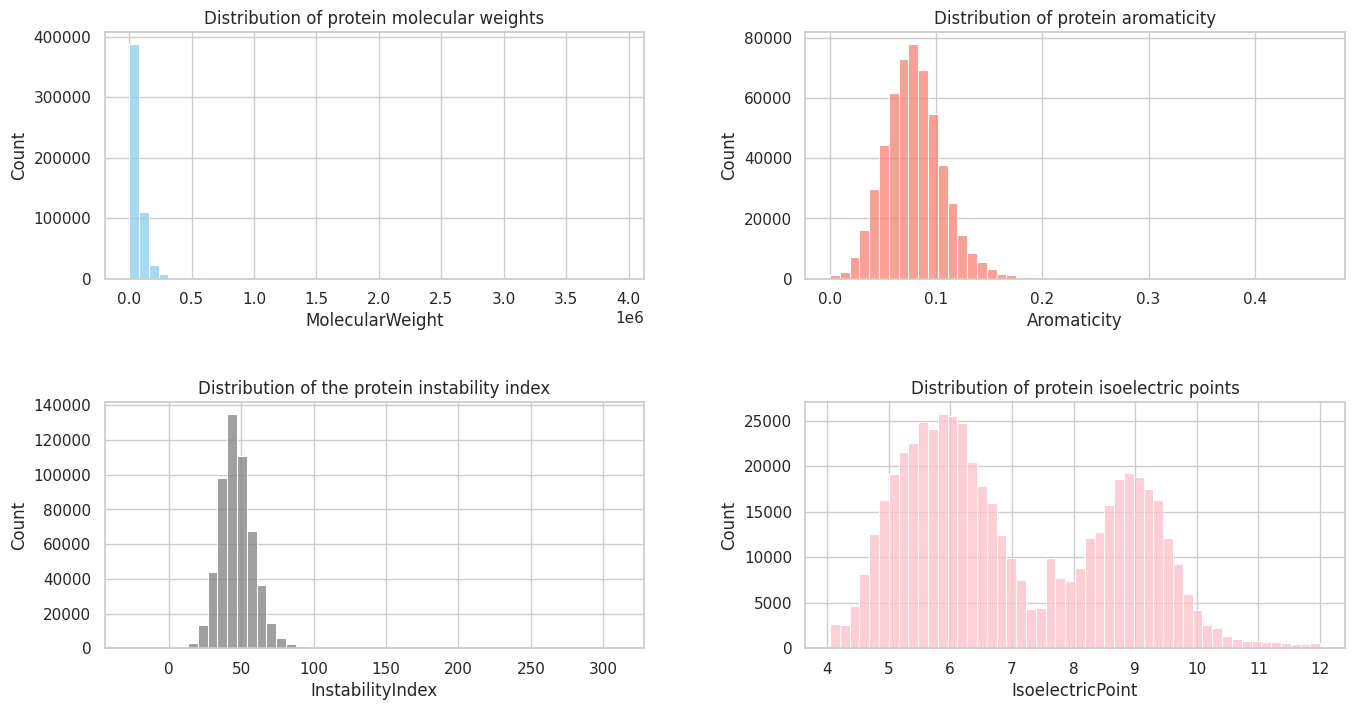

'x'

In [35]:
plt.figure(figsize=(16, 8))

plt.subplot(2, 2, 1)
sns.histplot(merged_data_sample['MolecularWeight'], bins=50, color='skyblue')
plt.title('Distribution of protein molecular weights')


plt.subplot(2, 2, 2)
sns.histplot(merged_data_sample['Aromaticity'], bins=50, color='salmon')
plt.title('Distribution of protein aromaticity')


plt.subplot(2, 2, 3)
sns.histplot(merged_data_sample['InstabilityIndex'], bins=50, color='gray')
plt.title('Distribution of the protein instability index')


plt.subplot(2, 2, 4)
sns.histplot(merged_data_sample['IsoelectricPoint'], bins=50, color = 'pink')
plt.title('Distribution of protein isoelectric points')

plt.subplots_adjust(hspace=0.5, wspace=0.3)

plt.show()
'x'

## Model training

In [36]:
# Dividing data into training and test sets

train_data, test_data = train_test_split(merged_data_sample, test_size=0.2, random_state=42)

In [37]:
train_data.shape, test_data.shape

((429108, 10), (107278, 10))

In [38]:
# Creating a vectorizer for amino acid sequences

tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(train_data['Sequence'])
X_train_sequence = tokenizer.texts_to_sequences(train_data['Sequence'])
X_test_sequence = tokenizer.texts_to_sequences(test_data['Sequence'])

In [39]:
# Padding sequences to the same length

average_length = int(sum(map(len, X_train_sequence)) / len(X_train_sequence))
max_sequence_length = average_length

X_train_sequence = pad_sequences(X_train_sequence, maxlen=max_sequence_length)
X_test_sequence = pad_sequences(X_test_sequence, maxlen=max_sequence_length)

In [40]:
# Create a vectorizer for the taxonomy

mlb = MultiLabelBinarizer()
y_train_taxonomy = mlb.fit_transform(train_data['Taxon_ID'])
y_test_taxonomy = mlb.transform(test_data['Taxon_ID'])

The model requires additional tuning, I tried different options for the `output_dim`, `Dropout`, `LSTM` parameters, but the result was either worse or almost the same. Haven't tried adding activation functions for hidden layers of ReLU or its variations such as Leaky ReLU, ELU or SELU

In [41]:
# # Try this

# model = Sequential()
# model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=500, input_length=max_sequence_length))
# model.add(Dropout(0.2))
# model.add(LSTM(100, activation='relu')) # Changing the activation function ## bad idea
# model.add(Dropout(0.2))
# model.add(Dense(len(mlb.classes_), activation='sigmoid'))
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [42]:
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=500, input_length=max_sequence_length)) 
model.add(Dropout(0.2))
model.add(LSTM(100)) 
model.add(Dropout(0.2))
model.add(Dense(len(mlb.classes_), activation='sigmoid')) 
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train_sequence, y_train_taxonomy, epochs=13, batch_size=32, validation_split=0.2)

Epoch 1/13
10728/10728 [==============================] - 453s 42ms/step - loss: 0.5244 - accuracy: 0.3959 - val_loss: 0.4865 - val_accuracy: 0.4278
Epoch 2/13
10728/10728 [==============================] - 446s 42ms/step - loss: 0.4677 - accuracy: 0.4788 - val_loss: 0.4523 - val_accuracy: 0.4748
Epoch 3/13
10728/10728 [==============================] - 447s 42ms/step - loss: 0.4426 - accuracy: 0.4943 - val_loss: 0.4284 - val_accuracy: 0.5482
Epoch 4/13
10728/10728 [==============================] - 447s 42ms/step - loss: 0.4273 - accuracy: 0.5011 - val_loss: 0.4205 - val_accuracy: 0.5215
Epoch 5/13
10728/10728 [==============================] - 445s 42ms/step - loss: 0.4173 - accuracy: 0.5082 - val_loss: 0.4086 - val_accuracy: 0.5160
Epoch 6/13
10728/10728 [==============================] - 445s 41ms/step - loss: 0.4103 - accuracy: 0.5124 - val_loss: 0.4031 - val_accuracy: 0.5390
Epoch 7/13
10728/10728 [==============================] - 445s 41ms/step - loss: 0.4038 - accuracy: 0.5158

In [43]:
# Model evaluation on test set

y_pred = model.predict(X_test_sequence)

y_pred_binary = (y_pred > 0.5).astype(int)

accuracy = accuracy_score(y_test_taxonomy, y_pred_binary)
f1 = f1_score(y_test_taxonomy, y_pred_binary, average='weighted')
precision = precision_score(y_test_taxonomy, y_pred_binary, average='weighted')
recall = recall_score(y_test_taxonomy, y_pred_binary, average='weighted')

print(f'Test Accuracy: {accuracy}, Test F1: {f1}, Test Precision: {precision}, Test Recall: {recall}')

3353/3353 [==============================] - 54s 16ms/step
Test Accuracy: 0.2266913999142415, Test F1: 0.6672879978310035, Test Precision: 0.7369456117451213, Test Recall: 0.6364308884615949


In [44]:
model.save('/kaggle/working/model_PFP.keras')

## Prediction on a test superset

In [45]:
# Download test protein sequences

# test_sequences = [str(record.seq) for record in SeqIO.parse('/kaggle/input/cafa-5-protein-function-prediction/Test (Targets)/testsuperset.fasta', 'fasta')]

In [46]:
# Create a DataFrame with protein sequences

test_data = pd.DataFrame({'Sequence': test_sequences})

In [47]:
average_length_test = int(sum(map(len, X_test_sequence)) / len(X_test_sequence))

max_sequence_length = average_length_test

In [48]:
X_test_sequence = pad_sequences(X_test_sequence, maxlen=max_sequence_length)

In [49]:
# Load taxonomy for test superset

# test_taxonomy = pd.read_csv('/kaggle/input/cafa-5-protein-function-prediction/Test (Targets)/testsuperset-taxon-list.tsv', sep='\t', encoding='ISO-8859-1')

In [50]:
sample_submission = pd.read_csv('/kaggle/input/cafa-5-protein-function-prediction/sample_submission.tsv', sep='\t')

In [51]:
# sample_submission

In [52]:
# # Prediction

# predictions = model.predict(X_test_sequence)

In [53]:
# predictions.shape

In [54]:
# test_taxonomy

In [55]:
from itertools import product
import numpy as np

In [56]:
test_embeddings = np.load('/kaggle/input/t5embeds/test_embeds.npy')

# Convert test_embeddings to dataframe
column_num = test_embeddings.shape[1]
test_df = pd.DataFrame(test_embeddings, columns = ["Column_" + str(i) for i in range(1, column_num+1)])
print(test_df.shape)


(141865, 1024)


In [57]:
selected_columns = test_df.columns[:636]
test_df_subset = test_df[selected_columns]

predictions = model.predict(test_df_subset)

4434/4434 [==============================] - 71s 16ms/step


In [58]:
# Set the limit for label
num_of_labels = 1500

# Take value counts in descending order and fetch first 1500 `GO term ID` as labels
labels = terms_data['GO_Term_ID'].value_counts().index[:num_of_labels].tolist()

In [59]:
if len(labels) > predictions.shape[1]:
    labels = labels[:predictions.shape[1]]
elif len(labels) < predictions.shape[1]:
    additional_labels = list(set(predictions.columns) - set(labels))
    labels.extend(additional_labels)


In [60]:
# Reference: https://www.kaggle.com/code/alexandervc/baseline-multilabel-to-multitarget-binary

df_submission = pd.DataFrame(columns=['Protein Id', 'GO Term Id', 'Prediction'])
test_protein_ids = np.load('/kaggle/input/t5embeds/test_ids.npy')

data = []

for i, protein_id in enumerate(test_protein_ids):
    for j, go_term_id in enumerate(labels):
        prediction_value = predictions[i, j]
        data.append({
            'Protein Id': protein_id,
            'GO Term Id': go_term_id,
            'Prediction': prediction_value
        })

df_submission = pd.DataFrame(data, columns=['Protein Id', 'GO Term Id', 'Prediction'])
df_submission.to_csv("submission.tsv", header=False, index=False, sep="\t")

In [61]:
df_submission

,Protein Id,GO Term Id,Prediction
0,Q9CQV8,GO:0005575,0.160532
1,Q9CQV8,GO:0008150,0.778950
2,Q9CQV8,GO:0110165,0.083364
3,Q9CQV8,GO:0003674,0.903193
4,Q9CQV8,GO:0005622,0.665724
...,...,...,...
1418645,A0A3G2FQK2,GO:0009987,0.491094
1418646,A0A3G2FQK2,GO:0043226,0.991221
1418647,A0A3G2FQK2,GO:0043229,0.039545
1418648,A0A3G2FQK2,GO:0005488,0.965599
